In [1]:
import os
import spacy
import warnings
import wordcloud
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import numpy as np
import pandas as pd 
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import textstat
import spacy
nlp = spacy.load('en_core_web_sm')

from spacy import displacy
from nltk.tokenize import sent_tokenize, word_tokenize 

import warnings
warnings.filterwarnings("ignore")

import contractions
import nltk
import string

#nltk.download('stopwords')
#from nltk.corpus import stopwords
#stop_words = set(stopwords.words('english'))

from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
nltk.download('wordnet')
nltk.download('omw-1.4')
import pkg_resources
from symspellpy import SymSpell, Verbosity

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/aishwariyagupta/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/aishwariyagupta/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [2]:
patient_notes = pd.read_csv("patient_notes.csv")
#one case number has many pn_num
features = pd.read_csv("features.csv")
#one case has many feature_num
train = pd.read_csv("train.csv")

train = train.merge(features, on=['feature_num', 'case_num'], how='left')
train = train.merge(patient_notes, on=['pn_num', 'case_num'], how='left')

pd.set_option('display.max_colwidth', None)
tain.head()

,id,case_num,pn_num,feature_num,annotation,location,feature_text,pn_history
0,00016_000,0,16,0,['dad with recent heart attcak'],['696 724'],Family-history-of-MI-OR-Family-history-of-myocardial-infarction,"HPI: 17yo M presents with palpitations. Patient reports 3-4 months of intermittent episodes of ""heart beating/pounding out of my chest."" 2 days ago during a soccer game had an episode, but this time had chest pressure and felt as if he were going to pass out (did not lose conciousness). Of note patient endorses abusing adderall, primarily to study (1-3 times per week). Before recent soccer game, took adderrall night before and morning of game. Denies shortness of breath, diaphoresis, fevers, chills, headache, fatigue, changes in sleep, changes in vision/hearing, abdominal paun, changes in bowel or urinary habits. \r\nPMHx: none\r\nRx: uses friends adderrall\r\nFHx: mom with ""thyroid disease,"" dad with recent heart attcak\r\nAll: none\r\nImmunizations: up to date\r\nSHx: Freshmen in college. Endorses 3-4 drinks 3 nights / week (on weekends), denies tabacco, endorses trying marijuana. Sexually active with girlfriend x 1 year, uses condoms"
1,00016_001,0,16,1,"['mom with ""thyroid disease']",['668 693'],Family-history-of-thyroid-disorder,"HPI: 17yo M presents with palpitations. Patient reports 3-4 months of intermittent episodes of ""heart beating/pounding out of my chest."" 2 days ago during a soccer game had an episode, but this time had chest pressure and felt as if he were going to pass out (did not lose conciousness). Of note patient endorses abusing adderall, primarily to study (1-3 times per week). Before recent soccer game, took adderrall night before and morning of game. Denies shortness of breath, diaphoresis, fevers, chills, headache, fatigue, changes in sleep, changes in vision/hearing, abdominal paun, changes in bowel or urinary habits. \r\nPMHx: none\r\nRx: uses friends adderrall\r\nFHx: mom with ""thyroid disease,"" dad with recent heart attcak\r\nAll: none\r\nImmunizations: up to date\r\nSHx: Freshmen in college. Endorses 3-4 drinks 3 nights / week (on weekends), denies tabacco, endorses trying marijuana. Sexually active with girlfriend x 1 year, uses condoms"


### Pre-processing the text column to clean it

In [4]:
train["pn_history_lower"] = train["pn_history"].str.lower()
regex = re.compile(r'<[^>]+>')
train["pn_history_noContractions"] = train["pn_history_lower"].apply(contractions.fix)

def remove_unicode_chars(text):
    text = text.encode("ascii", "ignore").decode()
    return text
train["pn_history_noUnicode"] = train["pn_history_noContractions"].apply(remove_unicode_chars)

def remove_punctuations(text):
    text = re.sub('[%s]' % re.escape(string.punctuation), " ",text)
    return text
train["pn_history_noPuncts"] = train["pn_history_noUnicode"].apply(remove_punctuations)

#def remove_stopwords(text):
#    return " ".join([word for word in str(text).split() if word not in stop_words])
#train["tweet_noStopwords"] = train["tweet_noPuncts"].apply(remove_stopwords)
def remove_extra_spaces(text):
    text = re.sub(' +', ' ', text).strip()
    return text
train["pn_history_noES"] = train["pn_history_noPuncts"].apply(remove_extra_spaces)
def lemmatize_text(text):
    words = [lemmatizer.lemmatize(word) for word in text.split()]
    text = ' '.join(words)
    return text
train["pn_history_preprocessed"] = train["pn_history_noES"].apply(lemmatize_text)

In [5]:
train = train.drop_duplicates(["pn_history_preprocessed"])

## Model 3 : KeyBert with Bio BERT Diseases NER

In [7]:
from keybert import KeyBERT
from tqdm import tqdm

In [8]:
model = KeyBERT(model="alvaroalon2/biobert_diseases_ner")

No sentence-transformers model found with name /Users/aishwariyagupta/.cache/torch/sentence_transformers/alvaroalon2_biobert_diseases_ner. Creating a new one with MEAN pooling.
Some weights of the model checkpoint at /Users/aishwariyagupta/.cache/torch/sentence_transformers/alvaroalon2_biobert_diseases_ner were not used when initializing BertModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertModel were not initialized from the model checkpoint at /Users/aishwariyagupta/.cache/torch/sentence_transformers/alvaroalon2_biobert_d

In [10]:
train.shape

(1000, 14)

## Applying KEYBERT Model

## Extracting 2 keywords

In [11]:
l = []
for index, row in tqdm(train.iterrows()):
    l.append(model.extract_keywords(
                row['pn_history_preprocessed'],
                top_n=3, 
                keyphrase_ngram_range=(1, 2),
                use_mmr=True, 
                diversity=0.7))

1000it [18:50,  1.13s/it]


In [12]:
train = train.reset_index(drop=True)

In [13]:
train = train.join(pd.DataFrame(l, columns=['first_keyword', 'second_keyword', 'third_keyword']))

In [15]:
train.to_csv("two_keywords_extraction_biobert_diseases_ner.csv")

In [16]:
#seprating keyword along with cosine similarity
def func(x):
    return x[1]
train['first_keyword_score'] = train.first_keyword.apply(lambda x: func(x))
def func(x):
    return x[0]
train['first_keyword'] = train.first_keyword.apply(lambda x: func(x))

def func(x):
    return x[1]
train['second_keyword_score'] = train.second_keyword.apply(lambda x: func(x))
def func(x):
    return x[0]
train['second_keyword'] = train.second_keyword.apply(lambda x: func(x))

def func(x):
    return x[1]
train['third_keyword_score'] = train.third_keyword.apply(lambda x: func(x))
def func(x):
    return x[0]
train['third_keyword'] = train.third_keyword.apply(lambda x: func(x))

In [17]:
train.to_csv("two_keywords_extraction_with_score_biobert_diseases_ner.csv")

## Extracting 3 keywords

In [18]:
l = []
for index, row in tqdm(train.iterrows()):
    l.append(model.extract_keywords(
                row['pn_history_preprocessed'],
                top_n=3,
                keyphrase_ngram_range=(1, 3),
                use_mmr=True, 
                diversity=0.7))

1000it [31:01,  1.86s/it]


In [19]:
train_new = train.join(pd.DataFrame(l, columns=['first_keyword_three', 'second_keyword_three', 'third_keyword_three']))

In [20]:
train.to_csv("three_keywords_extraction_biobert_diseases_ner.csv")

In [21]:
def func(x):
    return x[1]
train_new['first_keyword_score_three'] = train_new.first_keyword_three.apply(lambda x: func(x))
def func(x):
    return x[0]
train_new['first_keyword_three'] = train_new.first_keyword_three.apply(lambda x: func(x))

def func(x):
    return x[1]
train_new['second_keyword_score_three'] = train_new.second_keyword_three.apply(lambda x: func(x))
def func(x):
    return x[0]
train_new['second_keyword_three'] = train_new.second_keyword_three.apply(lambda x: func(x))

def func(x):
    return x[1]
train_new['third_keyword_score_three'] = train_new.third_keyword_three.apply(lambda x: func(x))
def func(x):
    return x[0]
train_new['third_keyword_three'] = train_new.third_keyword_three.apply(lambda x: func(x))

## Sample of Keyword with keyword scores

In [22]:
train_new[["first_keyword_score_three","first_keyword_three","second_keyword_three","second_keyword_score_three","third_keyword_three","third_keyword_score_three"]].sample(10)

,first_keyword_score_three,first_keyword_three,second_keyword_three,second_keyword_score_three,third_keyword_three,third_keyword_score_three
394,0.9612,urination palpitation med,bleeding,0.2401,constipation diarrhea,-0.3059
6,0.9730,time took aderol,pain tingling extremity,0.4103,thyroid disease,-0.2307
737,0.9780,day used tampon,heat intolerance,0.2715,allergy,-0.2350
165,0.9623,aggravates pain ibuprofuen,crampy,0.5021,diarrhea,-0.3125
466,0.9681,intrest concentration hx,difficulty falling asleep,0.3513,hypothyroid psychiatric disorder,-0.2382
196,0.9587,noncontributory sh sjhe,fever,0.1799,dysmenorrhoea,-0.4014
891,0.9733,hctz lisinopril fmhx,depression,0.0452,auditory hallucination,-0.4043
460,0.9691,ha stressful lecturing,falling,0.4148,edema,-0.1398
82,0.9643,drinker adderal use,denies dizziness intolerance,0.5277,diarrhea,-0.3037
642,0.9730,tyelonol prn fhx,muscle ache,0.4088,allergy,-0.1521


In [23]:
train.to_csv("three_keywords_extraction_with_score_biobert_diseases_ner.csv")

## Extracting 4 keywords

In [24]:
l = []
for index, row in tqdm(train.iterrows()):
    l.append(model.extract_keywords(
                row['pn_history_preprocessed'],
                top_n=3,
                keyphrase_ngram_range=(1, 4),
                use_mmr=True, 
                diversity=0.7))

1000it [42:11,  2.53s/it]


In [25]:
train_new['third_keyword_score_three'] = train_new['third_keyword_score']

In [26]:
train_new_new = train_new.join(pd.DataFrame(l, columns=['first_keyword_four', 'second_keyword_four', 'third_keyword_four']))


In [27]:
train_new_new.to_csv("four_keywords_extraction_biobert_diseases_ner.csv")

In [28]:
def func(x):
    return x[1]
train_new_new['first_keyword_score_four'] = train_new_new.first_keyword_four.apply(lambda x: func(x))
def func(x):
    return x[0]
train_new_new['first_keyword_four'] = train_new_new.first_keyword_four.apply(lambda x: func(x))

def func(x):
    return x[1]
train_new_new['second_keyword_score_four'] = train_new_new.second_keyword_four.apply(lambda x: func(x))
def func(x):
    return x[0]
train_new_new['second_keyword_four'] = train_new_new.second_keyword_four.apply(lambda x: func(x))

def func(x):
    return x[1]
train_new_new['third_keyword_score_four'] = train_new_new.third_keyword_four.apply(lambda x: func(x))
def func(x):
    return x[0]
train_new_new['third_keyword_four'] = train_new_new.third_keyword_four.apply(lambda x: func(x))

## Sample of Keyword with keyword scores

In [29]:
train_new_new[["first_keyword_score_four","first_keyword_four","second_keyword_score_four","second_keyword_four","third_keyword_three","third_keyword_score_three"]].sample(10)

,first_keyword_score_four,first_keyword_four,second_keyword_score_four,second_keyword_four,third_keyword_three,third_keyword_score_three
978,0.9740,obgyn report menstrual cycle,0.2672,pain,hypercholesteremia,-0.3704
674,0.9718,albuterol allergy nka hospitalisation,0.3058,pain,cough phlegm,-0.1710
511,0.9688,condominium atlanta report increased,0.5286,day palpitation associated,sexual trauma,-0.1577
514,0.9751,factor ro pmhx neg,0.5891,visit palpitation report,finger numbness,0.1032
58,0.9788,cosumes roommate prescription aldereol,0.4393,vomit nausea,allergy,-0.2185
528,0.9695,limit episode occcuring day,0.4437,alcohol illicit,night sweat allergy,-0.2496
552,0.9749,bought condo month ago,0.2776,pain,lupus,-0.1975
26,0.9791,college roomates prescription amphetimine,0.3605,sleep urinary bowel,heart attack,-0.0647
6,0.9796,college ha taking aderol,0.4361,palpitation ro,thyroid disease,-0.2307
898,0.9651,appendix med hctz 25mg,0.4213,fatigue,insomnia,-0.2024


In [30]:
train_new_new.to_csv("all_keywords_with_score_biobert_diseases_ner.csv")

In [32]:
train_with_scores = train_new_new.copy()

In [33]:
train_with_scores = pd.read_csv("all_keywords_with_score_biobert_diseases_ner.csv")

In [34]:
train_with_scores = train_with_scores[['id', 'case_num', 'pn_num', 'feature_num', 'annotation', 'location', 'feature_text', 'pn_history', 'pn_history_lower', 'pn_history_noContractions', 'pn_history_noUnicode', 'pn_history_noPuncts', 'pn_history_noES', 'pn_history_preprocessed', 'first_keyword', 'second_keyword', 'third_keyword', 'first_keyword_score', 'second_keyword_score', 'third_keyword_score', 'first_keyword_three', 'second_keyword_three', 'third_keyword_three', 'first_keyword_score_three', 'second_keyword_score_three', 'third_keyword_score_three', 'first_keyword_four', 'second_keyword_four', 'third_keyword_four', 'first_keyword_score_four', 'second_keyword_score_four', 'third_keyword_score_four']]

In [35]:
train_with_scores = train_with_scores.iloc[:,14:]

In [36]:
train_with_scores.first_keyword_score.quantile([0.25, 0.5, 0.75, 0.9])

0.25    0.95730
0.50    0.96240
0.75    0.96660
0.90    0.97021
Name: first_keyword_score, dtype: float64

In [37]:
train_with_scores.second_keyword_score.quantile([0.25, 0.5, 0.75, 0.9])

0.25    0.273400
0.50    0.334700
0.75    0.431625
0.90    0.506930
Name: second_keyword_score, dtype: float64

In [38]:
train_with_scores.third_keyword_score.quantile([0.25, 0.5, 0.75, 0.9])

0.25   -0.343775
0.50   -0.271450
0.75   -0.180750
0.90   -0.113670
Name: third_keyword_score, dtype: float64

### selecting those keywords which have a cosine similarity more than 0.25

In [39]:
train_with_scores.first_keyword = np.where(train_with_scores.first_keyword_score > 0.25, train_with_scores.first_keyword, np.nan)
train_with_scores.second_keyword = np.where(train_with_scores.second_keyword_score > 0.25, train_with_scores.second_keyword, np.nan)
train_with_scores.third_keyword = np.where(train_with_scores.third_keyword_score > 0.25, train_with_scores.third_keyword, np.nan)

In [40]:
train_with_scores.first_keyword_score.median(), train_with_scores.second_keyword_score.median(), train_with_scores.third_keyword_score.median()


(0.9624, 0.3347, -0.27144999999999997)

In [41]:
train_with_scores.first_keyword_three = np.where(train_with_scores.first_keyword_score_three > 0.25, train_with_scores.first_keyword_three, np.nan)
train_with_scores.second_keyword_three = np.where(train_with_scores.second_keyword_score_three > 0.25, train_with_scores.second_keyword_three, np.nan)
train_with_scores.third_keyword_three = np.where(train_with_scores.third_keyword_score_three > 0.25, train_with_scores.third_keyword_three, np.nan)


In [42]:
train_with_scores.first_keyword_four = np.where(train_with_scores.first_keyword_score_four > 0.25, train_with_scores.first_keyword_four, np.nan)
train_with_scores.second_keyword_four = np.where(train_with_scores.second_keyword_score_four > 0.25, train_with_scores.second_keyword_four, np.nan)
train_with_scores.third_keyword_four = np.where(train_with_scores.third_keyword_score_four > 0.25, train_with_scores.third_keyword_four, np.nan)


In [43]:
train_new_new = pd.read_csv("all_keywords_with_score_biobert_diseases_ner.csv")

In [44]:
train_with_scores = train_new_new[['id', 'pn_num', 'pn_history_preprocessed']].join(train_with_scores)

In [45]:
train_with_scores[:1].third_keyword.values

array([nan], dtype=object)

### Predicting Annotations

In [46]:
def func(x):
    all_annotation = []
    for annotation in [x.first_keyword, x.second_keyword, x.third_keyword, 
                       x.first_keyword_three, x.second_keyword_three, x.third_keyword_three,
                       x.first_keyword_four, x.second_keyword_four, x.third_keyword_four]:
        
        if str(annotation) != 'nan':
            all_annotation.append(str(annotation))
    return list(set(all_annotation))
    
train_with_scores['predicted_annotation'] = train_with_scores.apply(lambda x: func(x), axis=1)

In [47]:
train_with_scores[['pn_num', 'predicted_annotation']]

,pn_num,predicted_annotation
0,16,"[urinary habit pmhx, bowel urinary habit pmhx, urinary habit, fever chill headache, fatigue]"
1,41,"[ro neg pmh, drug mo, thyroid problem, ro neg pmh med, problem sh sex active]"
2,46,"[prescription adderall, gf use condom, heat intolerance, using roommate prescription adderall]"
3,82,"[headedness shortness breath pt, week time pt doe, week doe smoke, month episodic heart, dizziness change, week doe]"
4,100,"[headache dizziness loss conciousness, urinary habit ro, urinary habit, urinary habit ro hpi, pain]"
...,...,...
995,95145,"[urinary change, bowel urinary change, bending, appetitie change recent travel]"
996,95228,"[x2 day uri symptom, hx, day uri, photosensitivity, symptom x2 day]"
997,95243,"[patient ha tried tylenol, ha tried tylenol, chill chest, tried tylenol]"
998,95330,"[pain, 3x yesterday sick contact, yr usually mild, ha ibuprofen]"


In [48]:
train_with_scores.to_csv("final_annotations_biobert_diseases_ner")

### Evaluation Phase 1 : Using Fuzzy Wuzzy Techniques

In [50]:
train_with_scores = pd.read_csv("final_annotations_biobert_diseases_ner",index_col=[0])

In [51]:
from thefuzz import fuzz
from thefuzz import process

In [52]:
patient_notes_test = pd.read_csv("patient_notes.csv")
#one case number has many pn_num
features_test = pd.read_csv("features.csv")
#one case has many feature_num
test = pd.read_csv("train.csv")
test = test.merge(features_test, on=['feature_num', 'case_num'], how='left')
test = test.merge(patient_notes_test, on=['pn_num', 'case_num'], how='left')
test = test.merge(train_with_scores[['pn_num', 'pn_history_preprocessed']], on=['pn_num'], how='left')
pd.set_option('display.max_colwidth', None)
display(test.head(2))

,id,case_num,pn_num,feature_num,annotation,location,feature_text,pn_history,pn_history_preprocessed
0,00016_000,0,16,0,['dad with recent heart attcak'],['696 724'],Family-history-of-MI-OR-Family-history-of-myocardial-infarction,"HPI: 17yo M presents with palpitations. Patient reports 3-4 months of intermittent episodes of ""heart beating/pounding out of my chest."" 2 days ago during a soccer game had an episode, but this time had chest pressure and felt as if he were going to pass out (did not lose conciousness). Of note patient endorses abusing adderall, primarily to study (1-3 times per week). Before recent soccer game, took adderrall night before and morning of game. Denies shortness of breath, diaphoresis, fevers, chills, headache, fatigue, changes in sleep, changes in vision/hearing, abdominal paun, changes in bowel or urinary habits. \r\nPMHx: none\r\nRx: uses friends adderrall\r\nFHx: mom with ""thyroid disease,"" dad with recent heart attcak\r\nAll: none\r\nImmunizations: up to date\r\nSHx: Freshmen in college. Endorses 3-4 drinks 3 nights / week (on weekends), denies tabacco, endorses trying marijuana. Sexually active with girlfriend x 1 year, uses condoms",hpi 17yo m present with palpitation patient report 3 4 month of intermittent episode of heart beating pounding out of my chest 2 day ago during a soccer game had an episode but this time had chest pressure and felt a if he were going to pas out did not lose conciousness of note patient endorses abusing adderall primarily to study 1 3 time per week before recent soccer game took adderrall night before and morning of game denies shortness of breath diaphoresis fever chill headache fatigue change in sleep change in vision hearing abdominal paun change in bowel or urinary habit pmhx none rx us friend adderrall fhx mom with thyroid disease dad with recent heart attcak all none immunization up to date shx freshman in college endorses 3 4 drink 3 night week on weekend denies tabacco endorses trying marijuana sexually active with girlfriend x 1 year us condom
1,00016_001,0,16,1,"['mom with ""thyroid disease']",['668 693'],Family-history-of-thyroid-disorder,"HPI: 17yo M presents with palpitations. Patient reports 3-4 months of intermittent episodes of ""heart beating/pounding out of my chest."" 2 days ago during a soccer game had an episode, but this time had chest pressure and felt as if he were going to pass out (did not lose conciousness). Of note patient endorses abusing adderall, primarily to study (1-3 times per week). Before recent soccer game, took adderrall night before and morning of game. Denies shortness of breath, diaphoresis, fevers, chills, headache, fatigue, changes in sleep, changes in vision/hearing, abdominal paun, changes in bowel or urinary habits. \r\nPMHx: none\r\nRx: uses friends adderrall\r\nFHx: mom with ""thyroid disease,"" dad with recent heart attcak\r\nAll: none\r\nImmunizations: up to date\r\nSHx: Freshmen in college. Endorses 3-4 drinks 3 nights / week (on weekends), denies tabacco, endorses trying marijuana. Sexually active with girlfriend x 1 year, uses condoms",hpi 17yo m present with palpitation patient report 3 4 month of intermittent episode of heart beating pounding out of my chest 2 day ago during a soccer game had an episode but this time had chest pressure and felt a if he were going to pas out did not lose conciousness of note patient endorses abusing adderall primarily to study 1 3 time per week before recent soccer game took adderrall night before and morning of game denies shortness of breath diaphoresis fever chill headache fatigue change in sleep change in vision hearing abdominal paun change in bowel or urinary habit pmhx none rx us friend adderrall fhx mom with thyroid disease dad with recent heart attcak all none immunization up to date shx freshman in college endorses 3 4 drink 3 night week on weekend denies tabacco endorses trying marijuana sexually active with girlfriend x 1 year us condom


In [5]:
test.shape

(14300, 9)

In [53]:
test = test.merge(train_with_scores[['pn_num', 'predicted_annotation']], how='left', on='pn_num')

In [7]:
test.shape

(14300, 10)

In [54]:
evaluation = test[['pn_num', 'annotation', 'predicted_annotation', 'pn_history', 'pn_history_preprocessed']]
evaluation = evaluation[evaluation.annotation != '[]']
evaluation['annotation'] = evaluation['annotation'].astype(str)
evaluation['ground_truth_annotation'] = evaluation.annotation.apply(lambda x: eval(x))
evaluation = evaluation.explode('ground_truth_annotation')
evaluation['ground_truth_annotation_junk'] = evaluation.ground_truth_annotation.apply(lambda x: len(str(x)) < 3)

In [55]:
evaluation = evaluation.drop_duplicates()

In [57]:
evaluation.ground_truth_annotation_junk.value_counts(normalize=True)

False    0.940796
True     0.059204
Name: ground_truth_annotation_junk, dtype: float64

In [58]:
evaluation_pp = evaluation.copy()

In [59]:
evaluation['predicted_annotation'] = evaluation['predicted_annotation'].astype(str)
evaluation = evaluation[evaluation.predicted_annotation != '[]']
evaluation['prediction'] = evaluation.predicted_annotation.apply(lambda x: eval(x))
evaluation = evaluation.explode('prediction')

## Seprating columns which will be used for Fuzzy Wuzzy evaluation

In [60]:
cols = ['pn_num', 
       'pn_history_preprocessed', 
       'ground_truth_annotation',
       'prediction']
evaluation = evaluation[cols]

In [61]:
def get_fuzzy_wuzzy_score(x):
    prediction = x['prediction']
    label = x['ground_truth_annotation']
    return fuzz.partial_ratio(prediction, label)

evaluation['score'] = evaluation.apply(lambda x: get_fuzzy_wuzzy_score(x), axis=1)

<AxesSubplot:xlabel='score'>

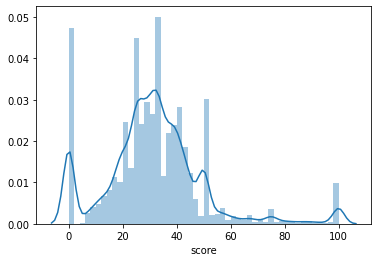

In [62]:
sns.distplot(evaluation.score)

### Evaluation Phase 2: Precision and Recall

## Precision

In [63]:
def relevance(x, threshold):
    all_predictions = x.groupby(['prediction']).agg({'score': 'max'}).reset_index()
    found_predictions = len(all_predictions[all_predictions['score'] >= threshold])
    return found_predictions, len(all_predictions)

In [64]:
threshold_values = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
all_relevant_predictions = pd.DataFrame()

for threshold_val in threshold_values:
    relevant_predictions = evaluation.groupby(['pn_num']).apply(lambda x: relevance(x, threshold=threshold_val))
    relevant_predictions = relevant_predictions.reset_index()
    relevant_predictions = pd.DataFrame(relevant_predictions[0].tolist(), index=relevant_predictions.pn_num)\
                            .rename(columns={0:f'found_labels', 1:f'total_predictions'})\
                            .reset_index()
    relevant_predictions[f'precision'] = relevant_predictions[f'found_labels'] / relevant_predictions[f'total_predictions']
    relevant_predictions['threshold'] = threshold_val
    all_relevant_predictions = pd.concat([all_relevant_predictions, relevant_predictions], axis=0)

## Recall

In [65]:
def retrieval(x, threshold):
    all_labels = x.groupby(['ground_truth_annotation']).agg({'score': 'max'}).reset_index()
    found_labels = len(all_labels[all_labels['score'] >= threshold])
    total_predictions = x['prediction'].nunique()
    
    return found_labels, len(all_labels)

In [66]:
threshold_values = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
all_retrieved_predictions = pd.DataFrame()

for threshold_val in threshold_values:
    retrieved_labels = evaluation.groupby(['pn_num']).apply(lambda x: retrieval(x, threshold=threshold_val))
    retrieved_labels = retrieved_labels.reset_index()
    retrieved_labels = pd.DataFrame(retrieved_labels[0].tolist(), index=retrieved_labels.pn_num)\
                        .rename(columns={0:f'found_predictions', 1:f'total_labels'})\
                        .reset_index()
    retrieved_labels['recall'] = retrieved_labels[f'found_predictions'] / retrieved_labels[f'total_labels']
    retrieved_labels['threshold'] = threshold_val
    all_retrieved_predictions = pd.concat([all_retrieved_predictions, retrieved_labels], axis=0)

In [67]:
evaluation_df = all_retrieved_predictions.merge(all_relevant_predictions, how='left', on=['pn_num', 'threshold'])
evaluation_df = evaluation_df[['pn_num', 'threshold', 'total_labels', 'total_predictions', 'found_labels', 'found_predictions', 'recall', 'precision']]

evaluation_df['f1_score'] = 2 * (evaluation_df['recall'] * evaluation_df['precision']) / (evaluation_df['recall'] + evaluation_df['precision'])
evaluation_df

,pn_num,threshold,total_labels,total_predictions,found_labels,found_predictions,recall,precision,f1_score
0,16,10,13,5,5,12,0.923077,1.00,0.960000
1,41,10,9,5,5,7,0.777778,1.00,0.875000
2,46,10,12,4,4,10,0.833333,1.00,0.909091
3,82,10,13,6,6,12,0.923077,1.00,0.960000
4,100,10,10,5,5,10,1.000000,1.00,1.000000
...,...,...,...,...,...,...,...,...,...
9995,95145,100,12,4,0,0,0.000000,0.00,NaN
9996,95228,100,7,5,1,1,0.142857,0.20,0.166667
9997,95243,100,10,4,0,0,0.000000,0.00,NaN
9998,95330,100,16,4,1,1,0.062500,0.25,0.100000


In [68]:
evaluation_df[evaluation_df.pn_num==16]

,pn_num,threshold,total_labels,total_predictions,found_labels,found_predictions,recall,precision,f1_score
0,16,10,13,5,5,12,0.923077,1.0,0.960000
1000,16,20,13,5,5,12,0.923077,1.0,0.960000
2000,16,30,13,5,5,11,0.846154,1.0,0.916667
3000,16,40,13,5,3,7,0.538462,0.6,0.567568
4000,16,50,13,5,1,1,0.076923,0.2,0.111111
5000,16,60,13,5,0,0,0.000000,0.0,NaN
6000,16,70,13,5,0,0,0.000000,0.0,NaN
7000,16,80,13,5,0,0,0.000000,0.0,NaN
8000,16,90,13,5,0,0,0.000000,0.0,NaN
9000,16,100,13,5,0,0,0.000000,0.0,NaN


In [69]:
biobert_diseases_ner_evaluation = evaluation_df.merge(test,on="pn_num",how="left")

In [70]:
biobert_diseases_ner_evaluation.to_csv("biobert_diseases_ner_evaluation.csv", index=False)

In [71]:
evaluation_df.to_csv("biobert_diseases_ner_evaluation_scores.csv",index=False)

### ------x-------------------x-----------------------x